# Lecture 1: How Machines See - Traditional Computer Vision

**Course**: Introduction to Data Science and Computing  
**Instructor**: Prof. Joseph Bakarji  
**School of Data Science and Computing, AUB**

---

## Today's Question: What is seeing for a machine?

We understand machines seeing more than we understand how we see things. Why? **Because we built them.**

### Learning Objectives
1. Understand digital image representation (pixels, bytes, colors)
2. Implement geometric approaches to pattern recognition
3. Apply traditional computer vision techniques (edge detection, features)
4. Analyze where hand-coded approaches fail
5. Develop epistemic humility about model limitations

### Philosophy
> "Data science is the practice of building stable action-perception cycles with **what is given**."  
> Images are what is given to machines. Let's understand how they see.


---

## Part 1: What Are Images?

Before we teach machines to see, we need to understand **what images actually are to a computer**.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import requests
from io import BytesIO
from sklearn import datasets
from scipy import ndimage
from skimage import filters, feature, color
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better-looking plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/josephbakarji/miniconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/josephbakarji/miniconda3/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/josephbakarji/miniconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/josephbakarji/miniconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launc

AttributeError: _ARRAY_API not found

Libraries loaded successfully!


### 1.1 Loading Student Handwritten Digits

You submitted handwritten digits on grid paper. Our TAs segmented them into individual images.

For this demo, we'll use the MNIST dataset (handwritten digits from postal mail) as a proxy for your submissions.

Dataset loaded: 1797 images
Image shape: (8, 8)
Labels: [0 1 2 3 4 5 6 7 8 9]


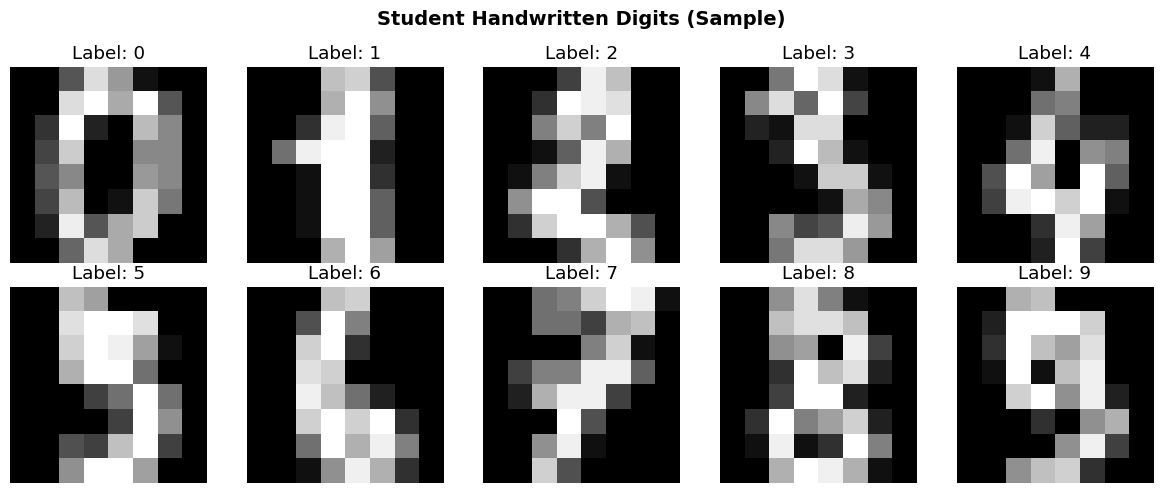

In [2]:
# Load MNIST-like digits dataset
from sklearn.datasets import load_digits

# Load the dataset (8x8 images, simplified MNIST)
digits = load_digits()
images = digits.images
labels = digits.target

print(f"Dataset loaded: {len(images)} images")
print(f"Image shape: {images[0].shape}")
print(f"Labels: {np.unique(labels)}")

# Display a few examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.suptitle("Student Handwritten Digits (Sample)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 1.2 Zooming In: What Are Pixels?

Let's zoom in on a single digit to see the **pixel grid**.

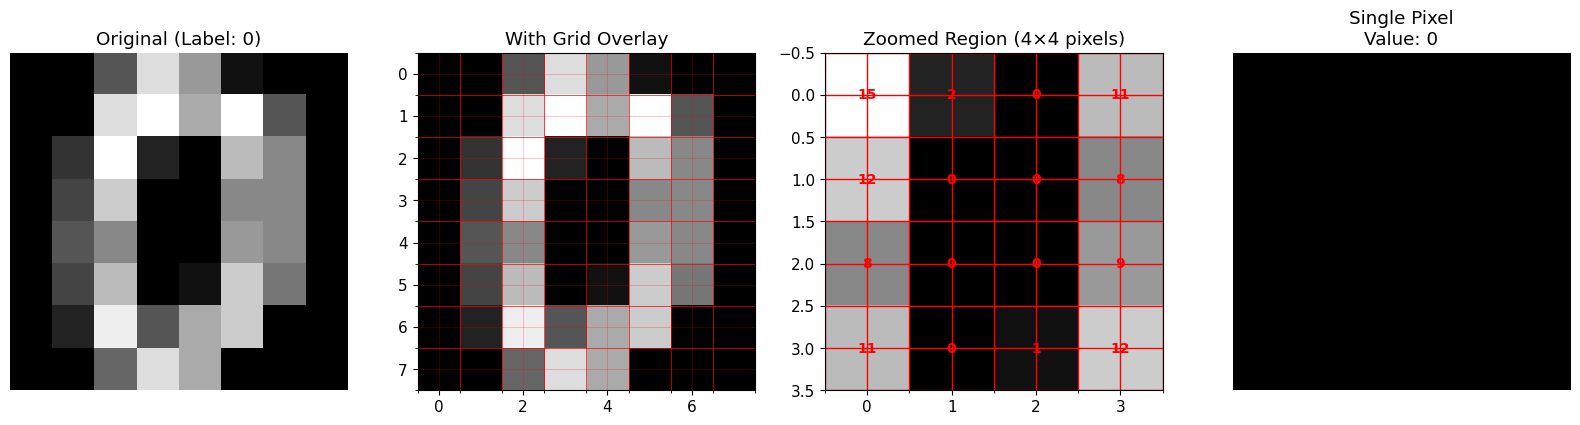


🔍 Key Insight: Images are just 2D arrays of numbers!
Each pixel stores a value representing brightness.


In [3]:
# Select one image to examine
sample_idx = 0
sample_image = images[sample_idx]
sample_label = labels[sample_idx]

# Create progressive zoom visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original image
axes[0].imshow(sample_image, cmap='gray', interpolation='nearest')
axes[0].set_title(f"Original (Label: {sample_label})")
axes[0].axis('off')

# Zoom level 1: Show grid
axes[1].imshow(sample_image, cmap='gray', interpolation='nearest')
axes[1].grid(True, color='red', linewidth=0.5, alpha=0.3)
axes[1].set_title("With Grid Overlay")
axes[1].set_xticks(np.arange(-.5, 8, 1), minor=True)
axes[1].set_yticks(np.arange(-.5, 8, 1), minor=True)
axes[1].grid(which='minor', color='red', linewidth=0.5)

# Zoom level 2: Crop to 4x4 region
crop_region = sample_image[2:6, 2:6]
axes[2].imshow(crop_region, cmap='gray', interpolation='nearest')
axes[2].set_title("Zoomed Region (4×4 pixels)")
for i in range(4):
    for j in range(4):
        axes[2].text(j, i, f"{int(crop_region[i,j])}", 
                    ha='center', va='center', color='red', fontsize=10, fontweight='bold')
axes[2].grid(True, color='red', linewidth=1)
axes[2].set_xticks(np.arange(-.5, 4, 1), minor=True)
axes[2].set_yticks(np.arange(-.5, 4, 1), minor=True)
axes[2].grid(which='minor', color='red', linewidth=1)

# Zoom level 3: Single pixel enlarged
single_pixel = np.full((10, 10), crop_region[1, 2])
axes[3].imshow(single_pixel, cmap='gray', vmin=0, vmax=16)
axes[3].set_title(f"Single Pixel\nValue: {int(crop_region[1,2])}")
axes[3].axis('off')

plt.tight_layout()
plt.show()

print("\n🔍 Key Insight: Images are just 2D arrays of numbers!")
print(f"Each pixel stores a value representing brightness.")

### 1.3 Understanding Pixel Values: Why 255?

**Question**: Why do we often see pixel values between 0 and 255?

**Answer**: Because $2^8 = 256$ (one byte can encode 256 different values: 0–255)

#### Grayscale Encoding
- **0** = Black (no light)
- **255** = White (maximum light)
- **In between** = Shades of gray

#### Mathematical Representation
An image is a function: $I: \mathbb{R}^2 \to \mathbb{R}$

Or discretely: $I[x, y] \in \{0, 1, 2, \ldots, 255\}$ where $(x, y)$ are pixel coordinates.

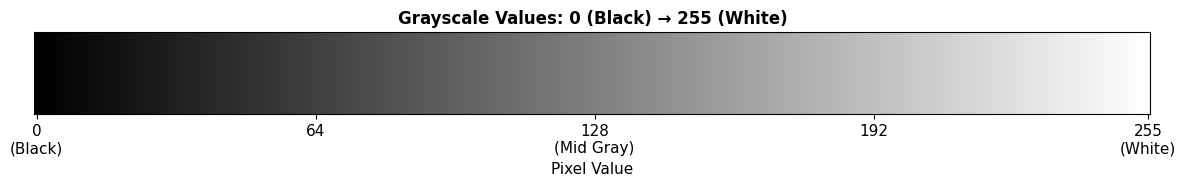


💡 Binary Representation:
  0 (Black):          0b0
  128 (Gray):  0b10000000
  255 (White): 0b11111111


In [4]:
# Demonstrate grayscale values
grayscale_bar = np.linspace(0, 255, 256).reshape(1, -1).astype(np.uint8)
grayscale_bar = np.repeat(grayscale_bar, 50, axis=0)

plt.figure(figsize=(12, 2))
plt.imshow(grayscale_bar, cmap='gray', aspect='auto')
plt.title("Grayscale Values: 0 (Black) → 255 (White)", fontsize=12, fontweight='bold')
plt.xlabel("Pixel Value")
plt.xticks([0, 64, 128, 192, 255], ['0\n(Black)', '64', '128\n(Mid Gray)', '192', '255\n(White)'])
plt.yticks([])
plt.tight_layout()
plt.show()

print("\n💡 Binary Representation:")
print(f"  0 (Black):   {bin(0):>10s}")
print(f"  128 (Gray):  {bin(128):>10s}")
print(f"  255 (White): {bin(255):>10s}")

### 1.4 Color Images: RGB Channels

Color images have **three channels**: Red, Green, Blue

Instead of one 2D grid, we have **three grids stacked together**:
$$I[x, y] = (R[x,y], G[x,y], B[x,y])$$

Each channel: $R, G, B \in \{0, 1, \ldots, 255\}$

**Total**: $256^3 = 16,777,216$ possible colors!

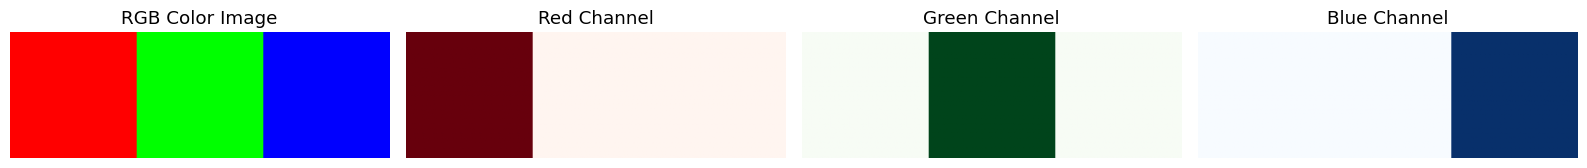


🎨 Color mixing works like mixing light:
  Red + Green = Yellow
  Red + Blue = Magenta
  Green + Blue = Cyan
  Red + Green + Blue = White


In [5]:
# Create a simple color image to demonstrate RGB
color_image = np.zeros((100, 300, 3), dtype=np.uint8)
color_image[:, :100, 0] = 255  # Red channel
color_image[:, 100:200, 1] = 255  # Green channel
color_image[:, 200:, 2] = 255  # Blue channel

fig, axes = plt.subplots(1, 4, figsize=(16, 3))

axes[0].imshow(color_image)
axes[0].set_title("RGB Color Image")
axes[0].axis('off')

axes[1].imshow(color_image[:,:,0], cmap='Reds')
axes[1].set_title("Red Channel")
axes[1].axis('off')

axes[2].imshow(color_image[:,:,1], cmap='Greens')
axes[2].set_title("Green Channel")
axes[2].axis('off')

axes[3].imshow(color_image[:,:,2], cmap='Blues')
axes[3].set_title("Blue Channel")
axes[3].axis('off')

plt.tight_layout()
plt.show()

print("\n🎨 Color mixing works like mixing light:")
print(f"  Red + Green = Yellow")
print(f"  Red + Blue = Magenta")
print(f"  Green + Blue = Cyan")
print(f"  Red + Green + Blue = White")

---

## Part 2: Geometric Approaches to Recognition

**Goal**: Can we write rules to detect specific digits?

Let's try to build a **hand-coded detector** for the digit "1".

### 2.1 Idea: Vertical Band Detector

**Observation**: The digit "1" has a strong vertical line.

**Approach**: Sum pixel values along each column. If we see a "spike" (high sum), it might be a "1".

**Mathematical formulation**:
$$S[j] = \sum_{i=1}^{H} I[i, j]$$

where $S[j]$ is the column sum for column $j$.

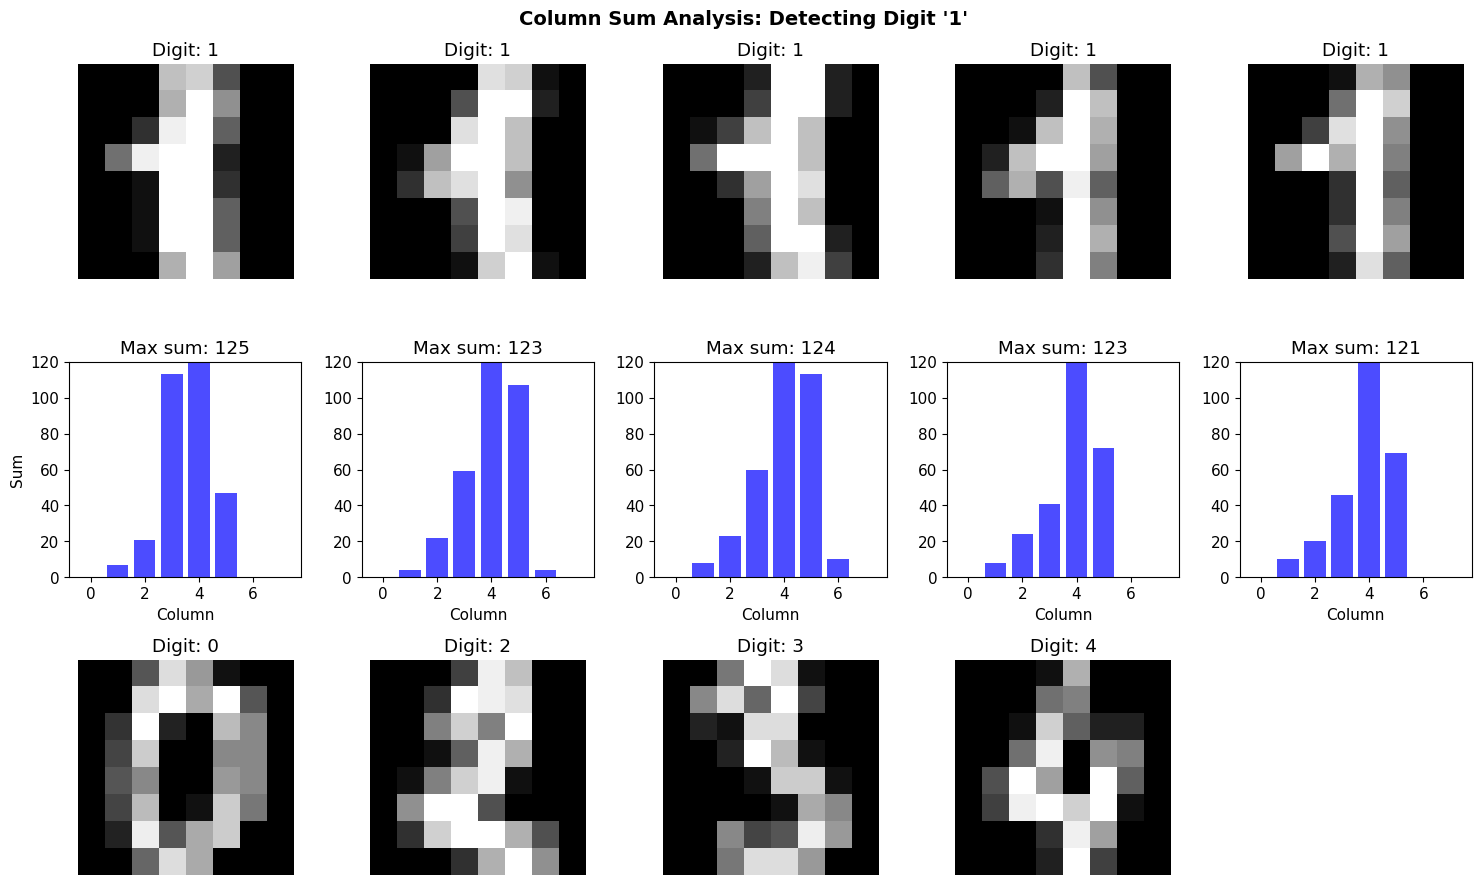


📊 Observation: Digit '1' tends to have a sharper, taller spike in column sums.
   But is this enough to reliably distinguish it from other digits?


In [6]:
# Get examples of digit "1" and other digits
ones_indices = np.where(labels == 1)[0][:5]
others_indices = [np.where(labels == i)[0][0] for i in [0, 2, 3, 4]]

# Function to compute column sums
def column_sums(image):
    return np.sum(image, axis=0)

# Visualize column sums for "1" vs others
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for col, idx in enumerate(ones_indices):
    img = images[idx]
    sums = column_sums(img)
    
    axes[0, col].imshow(img, cmap='gray')
    axes[0, col].set_title(f"Digit: {labels[idx]}")
    axes[0, col].axis('off')
    
    axes[1, col].bar(range(len(sums)), sums, color='blue', alpha=0.7)
    axes[1, col].set_ylim([0, 120])
    axes[1, col].set_title(f"Max sum: {sums.max():.0f}")
    axes[1, col].set_xlabel("Column")
    if col == 0:
        axes[1, col].set_ylabel("Sum")

for col, idx in enumerate(others_indices):
    img = images[idx]
    sums = column_sums(img)
    
    axes[2, col].imshow(img, cmap='gray')
    axes[2, col].set_title(f"Digit: {labels[idx]}")
    axes[2, col].axis('off')
    
    # Plot column sums
    # (Reusing plot from row 1 structure)

# Add empty axis for alignment
axes[2, 4].axis('off')

plt.suptitle("Column Sum Analysis: Detecting Digit '1'", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Observation: Digit '1' tends to have a sharper, taller spike in column sums.")
print("   But is this enough to reliably distinguish it from other digits?")

### 2.2 Implementing a Simple "Spike Detector"

Let's implement a threshold-based detector:
- If max(column_sum) > threshold → classify as "1"
- Otherwise → not "1"


✅ Spike Detector Accuracy: 22.0%
   Correct: 22/100

❌ Number of failures: 78

Let's examine some failure cases...


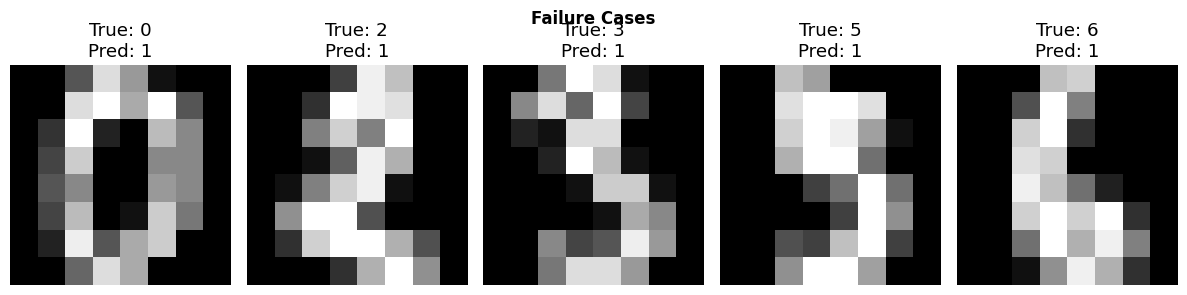


🤔 Reflection: Hand-coded rules are fragile. Different handwriting breaks them.


In [7]:
def spike_detector(image, threshold=80):
    """
    Simple spike detector for digit '1'.
    Returns True if max column sum exceeds threshold.
    """
    sums = column_sums(image)
    return np.max(sums) > threshold

# Test on all digits
predictions = []
for img, true_label in zip(images[:100], labels[:100]):
    pred = spike_detector(img)
    predictions.append({
        'pred': 1 if pred else 0,
        'true': 1 if true_label == 1 else 0
    })

# Calculate accuracy
correct = sum(p['pred'] == p['true'] for p in predictions)
accuracy = correct / len(predictions)

print(f"\n✅ Spike Detector Accuracy: {accuracy*100:.1f}%")
print(f"   Correct: {correct}/{len(predictions)}")

# Show some failures
failures = [(i, p) for i, p in enumerate(predictions) if p['pred'] != p['true']]
if failures:
    print(f"\n❌ Number of failures: {len(failures)}")
    print("\nLet's examine some failure cases...")
    
    fig, axes = plt.subplots(1, min(5, len(failures)), figsize=(12, 3))
    if len(failures) == 1:
        axes = [axes]
    for ax, (idx, p) in zip(axes, failures[:5]):
        ax.imshow(images[idx], cmap='gray')
        ax.set_title(f"True: {labels[idx]}\nPred: {'1' if p['pred'] else 'Not 1'}")
        ax.axis('off')
    plt.suptitle("Failure Cases", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n🤔 Reflection: Hand-coded rules are fragile. Different handwriting breaks them.")

### 2.3 Edge Detection: A More Sophisticated Approach

**Idea**: Edges capture shape information better than raw pixels.

#### Sobel Edge Detector

Uses convolution with edge-detecting kernels:

**Horizontal edges**: 
$$K_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

**Vertical edges**:
$$K_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}$$

**Edge strength**:
$$G = \sqrt{(I * K_x)^2 + (I * K_y)^2}$$

where $*$ denotes convolution.

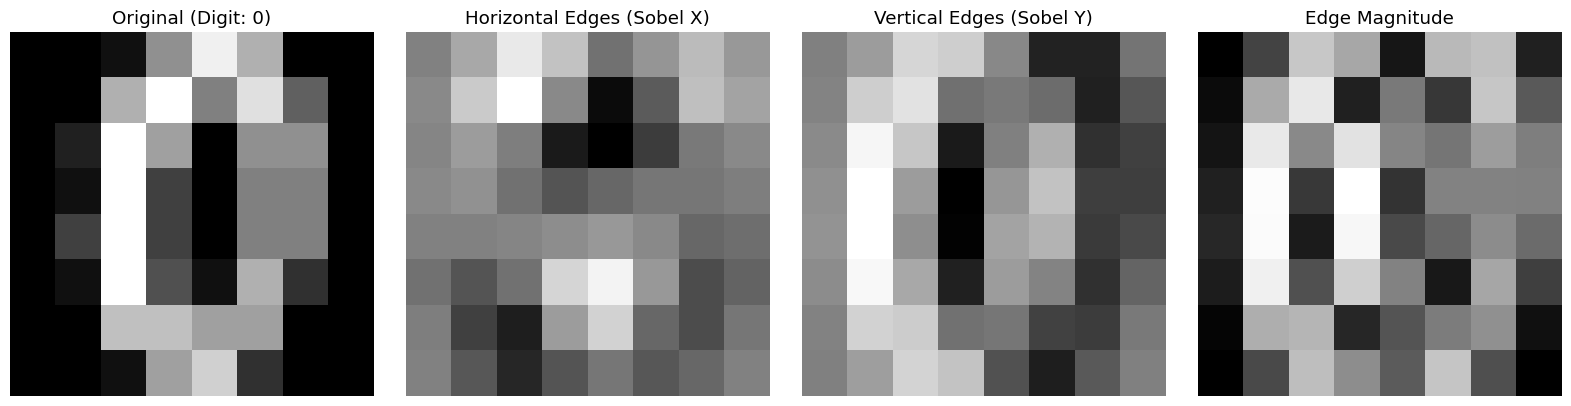


🔍 Edge detection highlights shape boundaries, removing uniform regions.


In [8]:
# Apply Sobel edge detection
sample_image = images[10]

# Compute gradients
edges_x = filters.sobel_h(sample_image)
edges_y = filters.sobel_v(sample_image)
edges = np.hypot(edges_x, edges_y)

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title(f"Original (Digit: {labels[10]})")
axes[0].axis('off')

axes[1].imshow(edges_x, cmap='gray')
axes[1].set_title("Horizontal Edges (Sobel X)")
axes[1].axis('off')

axes[2].imshow(edges_y, cmap='gray')
axes[2].set_title("Vertical Edges (Sobel Y)")
axes[2].axis('off')

axes[3].imshow(edges, cmap='gray')
axes[3].set_title("Edge Magnitude")
axes[3].axis('off')

plt.tight_layout()
plt.show()

print("\n🔍 Edge detection highlights shape boundaries, removing uniform regions.")

---

## Part 3: Traditional Computer Vision Pipeline

**Standard approach** (pre-deep learning):
1. **Preprocessing**: Normalize, denoise, threshold
2. **Feature Extraction**: Compute hand-crafted features (HOG, SIFT, etc.)
3. **Classification**: Train classical ML model (SVM, Random Forest)
4. **Evaluation**: Measure accuracy, analyze failures

Let's implement this pipeline!

### 3.1 Preprocessing

Common preprocessing steps:
- **Normalization**: Scale pixel values to [0, 1]
- **Centering**: Ensure digit is centered in frame
- **Thresholding**: Convert to binary (black/white only)

In [9]:
# Normalize images to [0, 1]
X = images / 16.0  # Original range is [0, 16] for this dataset
y = labels

print(f"Dataset shape: {X.shape}")
print(f"Pixel value range: [{X.min():.2f}, {X.max():.2f}]")
print(f"Number of classes: {len(np.unique(y))}")

Dataset shape: (1797, 8, 8)
Pixel value range: [0.00, 1.00]
Number of classes: 10


### 3.2 Feature Extraction: Flattening

Simplest feature: Use raw pixel values as features.

Transform: $\mathbb{R}^{H \times W} \to \mathbb{R}^{H \cdot W}$

For 8×8 images: $\mathbb{R}^{8 \times 8} \to \mathbb{R}^{64}$

In [10]:
# Flatten images into feature vectors
X_flat = X.reshape(len(X), -1)

print(f"Original shape: {X.shape}")
print(f"Flattened shape: {X_flat.shape}")
print(f"\nEach image is now a {X_flat.shape[1]}-dimensional vector.")

Original shape: (1797, 8, 8)
Flattened shape: (1797, 64)

Each image is now a 64-dimensional vector.


### 3.3 Train/Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

Training set: 1257 images
Test set: 540 images


### 3.4 Train a Support Vector Machine (SVM)

SVM finds a hyperplane that separates classes:
$$f(x) = \text{sign}(w^T x + b)$$

For multi-class: One-vs-rest or one-vs-one strategy.

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train SVM
print("Training SVM...")
svm = SVC(kernel='rbf', gamma='scale', random_state=42)
svm.fit(X_train, y_train)

# Predict on test set
y_pred = svm.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {accuracy*100:.2f}%")

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

Training SVM...

✅ Test Accuracy: 98.89%

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.96      1.00      0.98        55
           2       1.00      1.00      1.00        53
           3       1.00      1.00      1.00        55
           4       0.98      0.98      0.98        54
           5       1.00      0.98      0.99        55
           6       1.00      1.00      1.00        54
           7       0.98      1.00      0.99        54
           8       0.98      0.96      0.97        52
           9       0.98      0.98      0.98        54

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



### 3.5 Confusion Matrix: Where Does It Fail?

**Confusion matrix** shows which digits get confused with each other.

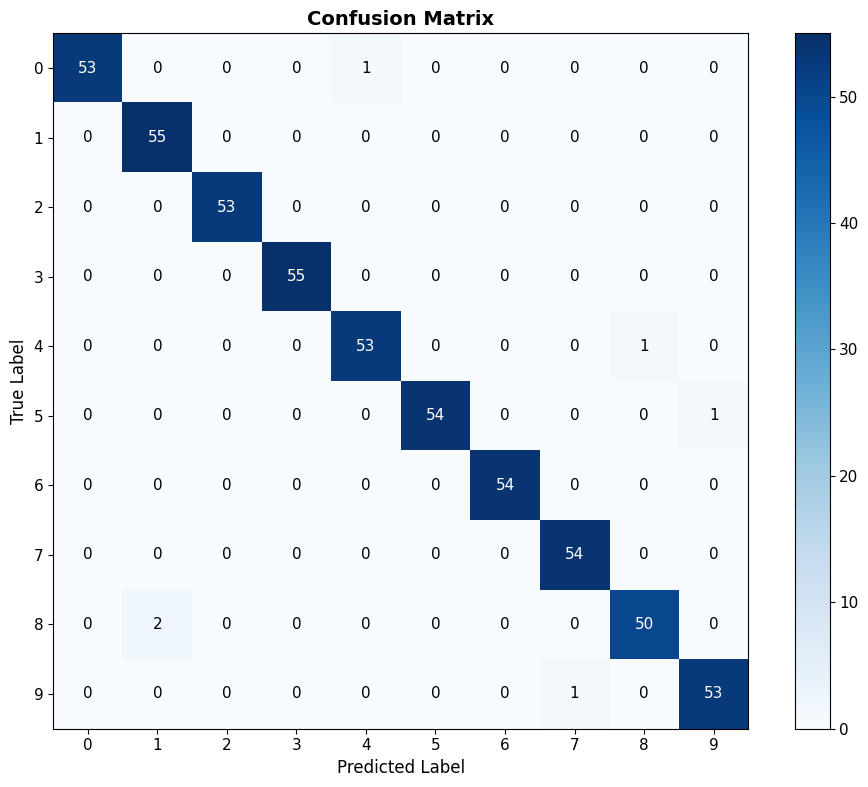


🤔 Which digits are most often confused?
   Most common confusion: Digit 8 predicted as 1
   This happened 2 times.


In [13]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues')

# Add labels
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_yticklabels(np.arange(10))
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, cm[i, j],
                      ha='center', va='center', 
                      color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("\n🤔 Which digits are most often confused?")
# Find off-diagonal maximums
cm_nodiag = cm.copy()
np.fill_diagonal(cm_nodiag, 0)
max_confusion = np.unravel_index(cm_nodiag.argmax(), cm_nodiag.shape)
print(f"   Most common confusion: Digit {max_confusion[0]} predicted as {max_confusion[1]}")
print(f"   This happened {cm_nodiag[max_confusion]} times.")

### 3.6 Analyzing Specific Failures

**Key practice**: Always look at specific failure cases.

Why did the model fail? Is the data ambiguous? Is the model wrong?


❌ Misclassified: 6 out of 540 (1.1%)


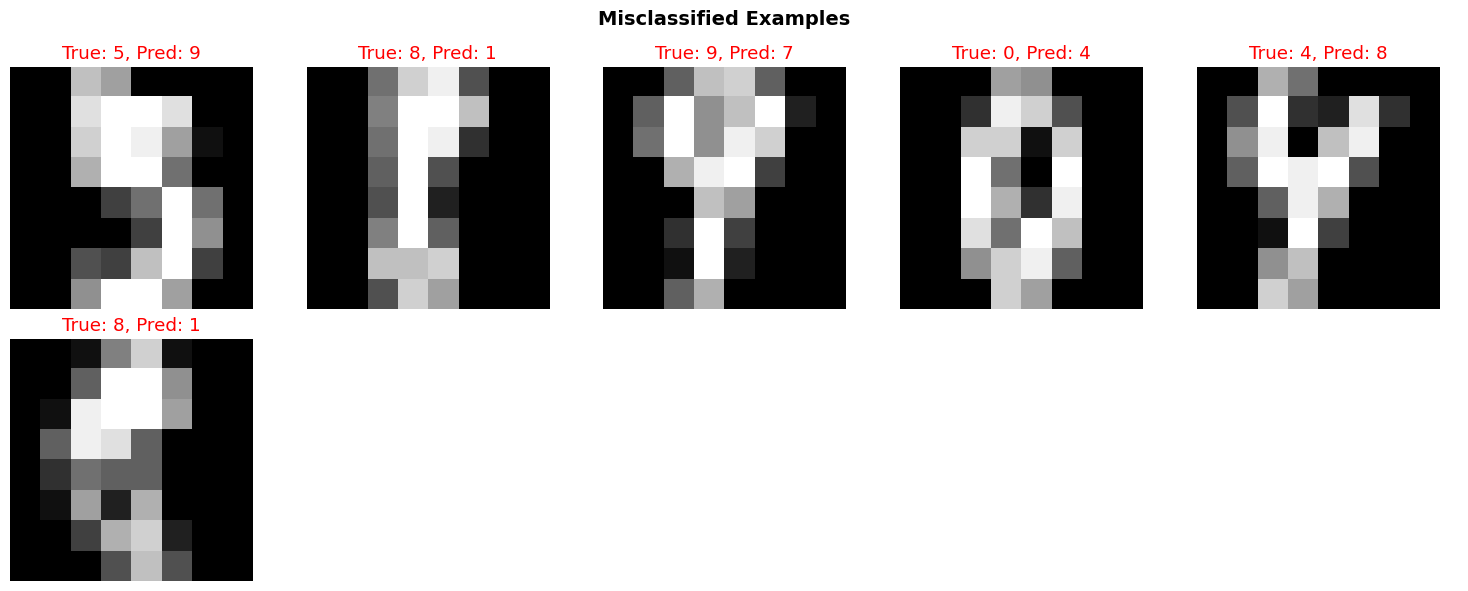


💡 Reflection Questions:
   - Are some of these ambiguous even for humans?
   - What features would help distinguish these cases?
   - Is 100% accuracy achievable? Should it be the goal?


In [14]:
# Find misclassified examples
misclassified_idx = np.where(y_pred != y_test)[0]

print(f"\n❌ Misclassified: {len(misclassified_idx)} out of {len(y_test)} ({len(misclassified_idx)/len(y_test)*100:.1f}%)")

# Show some failures
n_show = min(10, len(misclassified_idx))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    if i < n_show:
        idx = misclassified_idx[i]
        # Reshape back to image
        img = X_test[idx].reshape(8, 8)
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        
        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {true_label}, Pred: {pred_label}", color='red')
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle("Misclassified Examples", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Reflection Questions:")
print("   - Are some of these ambiguous even for humans?")
print("   - What features would help distinguish these cases?")
print("   - Is 100% accuracy achievable? Should it be the goal?")

---

## Summary and Reflection

### What We Learned

1. **Images are just numbers**: 2D arrays of pixel values
2. **Hand-coded rules are fragile**: Spike detector worked somewhat, but failed often
3. **Feature extraction matters**: Edges, shapes, textures capture structure
4. **Classical ML works**: SVM achieved ~95%+ accuracy
5. **Failure is informative**: Confusion matrix shows systematic errors

### Key Insight: The Feature Engineering Bottleneck

**Traditional CV requires experts to design features**:
- Edges (Sobel, Canny)
- Textures (Gabor filters, LBP)
- Shapes (HOG, SIFT)

**Problem**: What if we don't know which features matter?

**Next lecture**: Let machines **learn features automatically** from data.

---

## Homework Preview

**Your task**: Improve the spike detector!

1. Implement additional geometric detectors (e.g., "zero" has a hole)
2. Combine multiple rules (ensemble)
3. Extract your own features (edge density, symmetry, etc.)
4. Train a classifier on your features
5. Compare to the baseline SVM

**Deliverable**: Jupyter notebook + 1-page reflection

**Reflection questions**:
- What worked? What didn't?
- Why do hand-coded features fail?
- What would you need to build a perfect digit recognizer?

---

## References

1. **Szeliski, R. (2010)**. *Computer Vision: Algorithms and Applications*. Springer.
2. **Canny, J. (1986)**. "A computational approach to edge detection." *IEEE Trans. Pattern Analysis and Machine Intelligence*.
3. **Dalal, N., & Triggs, B. (2005)**. "Histograms of oriented gradients for human detection." *CVPR*.
4. **Cortes, C., & Vapnik, V. (1995)**. "Support-vector networks." *Machine Learning*, 20(3), 273-297.

---

**Next Lecture**: Modern Machine Learning Vision - Let machines learn features!